In [1]:
import os
import glob
def get_obs_file_pairs(obs_folder, obs_names):
    """
    Collects file1, file2, and gti paths for each observation.
    
    Args:
        obs_folder (str): Path to the folder containing observations.
        obs_names (list): List of observation directory names.
        file1_suffix (str): Filename suffix for file1.
        file2_suffix (str): Filename suffix for file2.
        gti_suffix (str): Filename suffix for GTI file.

    Returns:
        list of tuples: [(file1, file2, gti), ...]
    """
    obs_triplets = []
    for obs in obs_names:
        full_dir = os.path.join(obs_folder, obs)
        gti_path  = os.path.join(full_dir,  f"GTI_ixpe{obs}_evt2_v0*.txt")
        gti = glob.glob(gti_path)[0]
        full_dir = os.path.join(full_dir, "event_1pt5")
        file1_path = os.path.join(full_dir,  f"ixpe{obs}_det12*.fits")
        #print(file1_path)
        file1 = glob.glob(file1_path)[0]
        file2_path = os.path.join(full_dir, f"ixpe{obs}_det3*.fits")
        file2 = glob.glob(file2_path)[0]
        obs_triplets.append((file1, file2, gti))
    return obs_triplets


obs_dir='/home/c2032014/cygx1_paper/cyg_data_all'
obs_names=['01002901','01250101','03002201','03003101','03010001','03010101']
obs_triplets=get_obs_file_pairs(obs_dir, obs_names)

In [2]:
import numpy as np
from joblib import Parallel, delayed

norm='abs'
fmin=1
fmax=2
f_bin_number=4
Pmin=51
Pmax=200
gti_obs1='/home/c2032014/CYGX1/event_1pt5/GTI_ixpe01002901_evt1pt5_v01_src.txt'
gti_obs2='/home/c2032014/cyg_june/CYGX1_JUNE/event_1pt5/GTI_ixpe01250101_evt1pt5_v01_src.txt'
bin_length=1/64
seg_length=16
fmin=0
fmax=4
f_bin_number=2
mod_min=np.radians(-90)
mod_max=np.radians(90)
mod_bin_number=20
J=mod_bin_number
spur_sub=True
coherence_corrector=False
output_file='/home/c2032014/cygx1_paper/stacked_qu_test_2bin.npy'

In [8]:
#Importing basics
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import scipy
from scipy.optimize import curve_fit

#Importing my functions
import sys
sys.path.append('/home/c2032014/py_files')
import load_and_clean as lac
import fit_rms_phase as frp
import F_test as ft
import chi_square as chis
import get_obs_file_triplets as g
import get_obs_file_triplets as gft
import G_span_abs as gs
#Importing parallel processing packages
from joblib import Parallel, delayed

#Importing stingray packages
from stingray import Lightcurve, Powerspectrum, AveragedCrossspectrum


# Example function to process one observation triplet
def process_obs_triplet(obs, Pmin, Pmax, bin_length,
                        seg_length, fmin, fmax,spur_sub,
                        norm,mod_bin_number,mod_min,mod_max,
                        coherence_corrector=None):
    


    #print(obs)
    data1, *_ = lac.load_and_clean(obs[0], Pmin, Pmax)
    data2, *_ = lac.load_and_clean(obs[1], Pmin, Pmax)
    GTI = list(np.loadtxt(obs[2]))

    I_obs = len(data1['TIME'])
    Q_obs = data1['Q']
    U_obs = data1['U']

    Q_norm = np.sum(Q_obs) / I_obs
    U_norm = np.sum(U_obs) / I_obs

    # Loading and cleaning data


    lc1 = Lightcurve.make_lightcurve(data1['TIME'], dt=bin_length, gti=GTI)
    lc2 = Lightcurve.make_lightcurve(data2['TIME'], dt=bin_length, gti=GTI)
    lc1.apply_gtis()
    lc2.apply_gtis()

    # cs ref needed for null calculation
    cs_ref = AveragedCrossspectrum.from_lightcurve(lc1, lc2, seg_length, norm='abs')
    ps_2_ref = Powerspectrum.from_lightcurve(lc2, seg_length, norm='abs')
  
    aspace = np.linspace(mod_min, mod_max, mod_bin_number + 1)
    mod_min_array = aspace[:-1]
    mod_max_array = aspace[1:]
    av_mod = (mod_min_array + mod_max_array) / 2
    av_mod_err = (mod_max_array - mod_min_array) / 2
   
    G_real_span, G_im_span, n_span, m_span,lc_1_sub_span,lc_spur,cs,spur_sub_norm = gs.G_span(mod_bin_number, data1, lc2, GTI, bin_length, seg_length, fmin, fmax, spur_sub, norm)




    return {
        "I_obs": I_obs,
        "Q_obs": Q_obs,
        "U_obs": U_obs,
        "Q_norm": Q_norm,
        "U_norm": U_norm,
        "cs_ref": cs_ref,
        "cs_G": cs,
        "weights_ref" : cs_ref.m,
        "weights_G": [cs.m for cs in cs],
        "ps_2_ref": ps_2_ref,
        



    }

In [9]:
#Define sinusoidal models to fit Re[G] and Im[G] 
def cross_spec_model_real(phi,A,B,C):
    Re_G=(1/J) * ( A + (B*np.cos(2*phi)) + (C*np.sin(2*phi)) )
    return Re_G

#The imaginary sinusoid does not have the A term
def cross_spec_model_imag(phi,B,C):
    Im_G=(1/J) * ( (B*np.cos(2*phi)) + (C*np.sin(2*phi)) )
    return Im_G

def cross_spec_model_null(phi, C_nu_mag_sqrd,Q_norm,U_norm):
    return (1/J) * C_nu_mag_sqrd * (1 + Q_norm * np.cos(2 * phi) + U_norm * np.sin(2 * phi))




In [26]:
#def run_q_u_nu_stack(obs_folder, obs_names, Pmin, Pmax, bin_length,
 #                               seg_length, fmin, fmax,f_bin_number,
 #                               mod_bin_number,mod_min,mod_max, spur_sub, coherence_corrector,
 #                               norm, output_file):
    #obs_triplets = gft.get_obs_file_pairs(obs_folder, obs_names)
    # Parallel processing of obs_triplets
    
    
results = Parallel(n_jobs=-1)(delayed(process_obs_triplet)(
        obs, Pmin, Pmax, bin_length, seg_length, fmin, fmax,
        spur_sub, norm, mod_bin_number,mod_min,mod_max,
        coherence_corrector=False
    ) for obs in obs_triplets)


#print(results)

aspace = np.linspace(mod_min, mod_max, mod_bin_number + 1)
mod_min_array = aspace[:-1]
mod_max_array = aspace[1:]
av_mod = (mod_min_array + mod_max_array) / 2
av_mod_err = (mod_max_array - mod_min_array) / 2

  #Making frequency list
fspace = np.linspace(fmin, fmax, f_bin_number + 1)
f_min_array, f_max_array = fspace[:-1], fspace[1:]
f_angle_list = list(zip(f_min_array, f_max_array))
av_f = (f_min_array + f_max_array) / 2
av_f_err = (f_max_array - f_min_array) / 2


# Unpack the results
I_obs_arr = [r["I_obs"] for r in results]
Q_obs_arr = [r["Q_obs"] for r in results]
U_obs_arr = [r["U_obs"] for r in results]
cs_ref_obs = [r["cs_ref"] for r in results]
cs_G_obs = [r["cs_G"] for r in results]
weights_ref_obs = [r["weights_ref"] for r in results]
weights_G_obs = [r["weights_G"] for r in results]
ps_2_ref = [r["ps_2_ref"] for r in results]

cs_G_obs_real = [[cs.power.real for cs in sublist] for sublist in cs_G_obs]
cs_G_obs_imag = [[cs.power.imag for cs in sublist] for sublist in cs_G_obs]

cs_ref_obs_real = [cs_ref.power.real for cs_ref in cs_ref_obs]
cs_ref_obs_imag = [cs_ref.power.imag for cs_ref in cs_ref_obs]

print('test',cs_G_obs.freq)



I_tot=np.sum(I_obs_arr)
Q_norm=sum(sum(sublist) for sublist in Q_obs_arr)/I_tot
U_norm=sum(sum(sublist) for sublist in U_obs_arr)/I_tot




#Stacking the results
#cs_G_real_stacked=np.average(cs_G_obs_real,weights=weights_G_obs,axis=0)
#cs_G_imag_stacked=np.average(cs_G_obs_imag,weights=weights_G_obs,axis=0)

#cs_ref_real_stacked=np.average(cs_ref_obs_real,weights=weights_ref_obs,axis=0)
#cs_ref_imag_stacked=np.average(cs_ref_obs_imag,weights=weights_ref_obs,axis=0)
    
#results_freq = Parallel(n_jobs=-1)(delayed(process_frequency_bin)(i,fmin,fmax,f_bin_number,weights_G_obs,weights_ref_obs,ps_2_ref,cs_ref_obs,cs_G_obs,av_mod,Q_norm,
#                          U_norm) for i in range(len(f_angle_list)))



    #np.savetxt(output_file, results_freq)


num of events 1365526
num of events 1777702
num of events 1701018
num of events 1813589
num of events 3883959
num of events 632960
num of events 785926
num of events 823553
num of events 9678551
num of events 842912
num of events 1807055
num of events 4450960


AttributeError: 'list' object has no attribute 'freq'

In [31]:
print('test',cs_G_obs[2][5].freq)

test [ 0.0625  0.125   0.1875  0.25    0.3125  0.375   0.4375  0.5     0.5625
  0.625   0.6875  0.75    0.8125  0.875   0.9375  1.      1.0625  1.125
  1.1875  1.25    1.3125  1.375   1.4375  1.5     1.5625  1.625   1.6875
  1.75    1.8125  1.875   1.9375  2.      2.0625  2.125   2.1875  2.25
  2.3125  2.375   2.4375  2.5     2.5625  2.625   2.6875  2.75    2.8125
  2.875   2.9375  3.      3.0625  3.125   3.1875  3.25    3.3125  3.375
  3.4375  3.5     3.5625  3.625   3.6875  3.75    3.8125  3.875   3.9375
  4.      4.0625  4.125   4.1875  4.25    4.3125  4.375   4.4375  4.5
  4.5625  4.625   4.6875  4.75    4.8125  4.875   4.9375  5.      5.0625
  5.125   5.1875  5.25    5.3125  5.375   5.4375  5.5     5.5625  5.625
  5.6875  5.75    5.8125  5.875   5.9375  6.      6.0625  6.125   6.1875
  6.25    6.3125  6.375   6.4375  6.5     6.5625  6.625   6.6875  6.75
  6.8125  6.875   6.9375  7.      7.0625  7.125   7.1875  7.25    7.3125
  7.375   7.4375  7.5     7.5625  7.625   7.6875  7.75  

In [34]:
print(cs_ref_obs[0].freq)

[ 0.0625  0.125   0.1875  0.25    0.3125  0.375   0.4375  0.5     0.5625
  0.625   0.6875  0.75    0.8125  0.875   0.9375  1.      1.0625  1.125
  1.1875  1.25    1.3125  1.375   1.4375  1.5     1.5625  1.625   1.6875
  1.75    1.8125  1.875   1.9375  2.      2.0625  2.125   2.1875  2.25
  2.3125  2.375   2.4375  2.5     2.5625  2.625   2.6875  2.75    2.8125
  2.875   2.9375  3.      3.0625  3.125   3.1875  3.25    3.3125  3.375
  3.4375  3.5     3.5625  3.625   3.6875  3.75    3.8125  3.875   3.9375
  4.      4.0625  4.125   4.1875  4.25    4.3125  4.375   4.4375  4.5
  4.5625  4.625   4.6875  4.75    4.8125  4.875   4.9375  5.      5.0625
  5.125   5.1875  5.25    5.3125  5.375   5.4375  5.5     5.5625  5.625
  5.6875  5.75    5.8125  5.875   5.9375  6.      6.0625  6.125   6.1875
  6.25    6.3125  6.375   6.4375  6.5     6.5625  6.625   6.6875  6.75
  6.8125  6.875   6.9375  7.      7.0625  7.125   7.1875  7.25    7.3125
  7.375   7.4375  7.5     7.5625  7.625   7.6875  7.75    7.8

In [23]:
print(f_angle_list)

[(0.0, 2.0), (2.0, 4.0)]


In [69]:


weights_expanded_obs = np.array(weights_G_obs)[:, :, np.newaxis]
#weights_expanded_ref = weights_ref_obs[:, :, np.newaxis]

# Weighted sum over axis=0
numerator_obs_real = np.sum(cs_G_obs_real * weights_expanded_obs, axis=0)       # (20, 511)
denominator_obs_real = np.sum(weights_expanded_obs, axis=0)                     # (20, 1)

numerator_obs_imag = np.sum(cs_G_obs_imag * weights_expanded_obs, axis=0)       # (20, 511)
denominator_obs_imag = np.sum(weights_expanded_obs, axis=0)                     # (20, 1)



# Final weighted average
cs_G_real_stacked = numerator_obs_real / np.where(denominator_obs_real == 0, np.nan, denominator_obs_real)
cs_G_imag_stacked = numerator_obs_imag / np.where(denominator_obs_imag == 0, np.nan, denominator_obs_imag)

#Stacking the results
#cs_G_real_stacked=np.average(cs_G_obs_real,weights=weights_G_obs,axis=0)
#cs_G_imag_stacked=np.average(cs_G_obs_imag,weights=weights_G_obs,axis=0)

cs_ref_real_stacked=np.average(cs_ref_obs_real,weights=weights_ref_obs,axis=0)
cs_ref_imag_stacked=np.average(cs_ref_obs_imag,weights=weights_ref_obs,axis=0)
    

In [96]:

results_freq = Parallel(n_jobs=-1)(delayed(process_frequency_bin)(i,cs_G_real_stacked,cs_G_imag_stacked,cs_G_obs[0][0].freq,av_mod,Q_norm,
                          U_norm) for i in (f_angle_list))


0.0
2.0
2.0
(20, 511)
4.0
(20, 511)
G_realG_real  [0.07231258341090746, 0.06512387118641103, 0.07752441714317092, 0.06772316311328509, 0.07004642047073625, 0.07179725981194757, 0.06598080334375969, 0.062419678007774294, 0.06606898969786539, 0.07535668130242364, 0.06783418727771483, 0.0716791792920257, 0.06761594369411954, 0.07570941241618638, 0.06742230749942632, 0.06884413491790628, 0.06894038407477732, 0.0769960261455292, 0.07373833264731729, 0.06914389429965466]
[0.46020295897091956, 0.4607307301345529, 0.4616850828384078, 0.46198127668906597, 0.4627406289262082, 0.4569746899784569, 0.47375158712266413, 0.4693253749065218, 0.4637878597647971, 0.4782479101590734, 0.46565057842507696, 0.46760327642364996, 0.46792168097022335, 0.461837111736652, 0.46860947375065504, 0.4640810069740151, 0.45917449686614376, 0.46101818292547436, 0.4652389027646765, 0.4641307244999022]
cs_ref_real_mean cs_ref_real_mean 1.4020602575076004
9.293261906680543
params real params real [ 1.40227767 -0.02851885  

In [87]:
import pandas as pd
df=pd.DataFrame(results_freq)
print(df)

   f_av  A_real_err  B_real_err  C_real_err  B_imag_err  C_imag_err    A_real  \
0   1.0    0.019567    0.027672    0.027673    0.031129    0.031129  9.294694   
1   3.0    0.018619    0.026331    0.026331    0.031869    0.031869  1.402278   

     B_real    C_real    B_imag    C_imag  A_null_real  B_null_real  \
0  0.081595  0.001314 -0.030995 -0.014372     9.293320     0.065406   
1 -0.028519  0.024661 -0.007529 -0.058643     1.402075     0.009868   

   C_null_real  B_null_imag  
0    -0.063476            0  
1    -0.009577            0  


<ErrorbarContainer object of 3 artists>

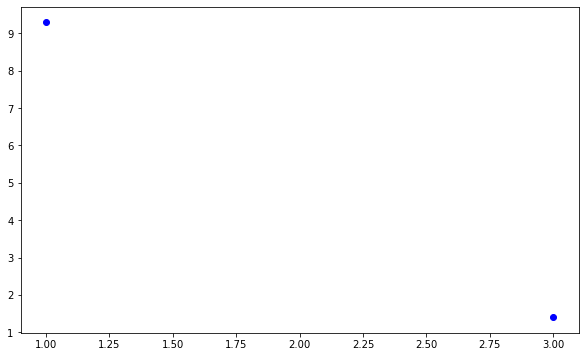

In [88]:
plt.figure(figsize=(10, 6))
plt.errorbar(df['f_av'], df['A_real'], yerr=df['A_real_err'], fmt='o', label='Re[G]', color='blue')

In [95]:
def process_frequency_bin(i,cs_G_real_stacked,cs_G_imag_stacked,cs_freqs,av_mod,Q_norm,U_norm):
    print(i[0])
    print(i[1])
    #Arrays for results
    A_real_arr= []
    B_real_arr= []
    C_real_arr= []

    B_imag_arr= []
    C_imag_arr= []

    A_real_err_arr= []
    B_real_err_arr= []
    C_real_err_arr= []
    B_imag_err_arr= []
    C_imag_err_arr= []

    #fspace = np.linspace(fmin, fmax, f_bin_number + 1)
    #f_min_array, f_max_array = fspace[:-1], fspace[1:]
    #f_angle_list = list(zip(f_min_array, f_max_array))
    #av_f = (f_min_array + f_max_array) / 2
    #av_f_err = (f_max_array - f_min_array) / 2
    #f_min = f_angle_list[i][0]
    #f_max = f_angle_list[i][1]
    #print(f_angle_list)
    print(cs_G_real_stacked.shape)

    G_real=[cs_G_real_stacked[(i[0]<=cs_freqs) & (cs_freqs<=i[1])].mean() for cs_G_real_stacked in cs_G_real_stacked]
    G_imag=[cs_G_imag_stacked[(i[0]<=cs_freqs) & (cs_freqs<=i[1])].mean() for cs_G_imag_stacked in cs_G_imag_stacked]
    print('G_real',G_real)

    cs_ref_real_mean=np.array(cs_ref_real_stacked[(i[0] <= cs_freqs) & (cs_freqs <= i[1])].mean())
    cs_ref_imag_mean=np.array(cs_ref_imag_stacked[(i[0] <= cs_freqs) & (cs_freqs <= i[1])].mean())
    print('cs_ref_real_mean',cs_ref_real_mean)
    #G_real = np.average([[cs.power.real[(fmin <= cs.freq) & (cs.freq <= fmax)].mean() for cs in sublist] for sublist in cs_G_obs],weights=weights_G,axis=0)
    #G_imag = np.average([[cs.power.imag[(fmin <= cs.freq) & (cs.freq <= fmax)].mean() for cs in sublist] for sublist in cs_G_obs],weights=weights_G,axis=0)
    #cs_ref_real_mean=np.average([cs_ref.power.real[(fmin <= cs_ref.freq) & (cs_ref.freq <= fmax)].mean() for cs_ref in cs_ref_obs],weights=weights_ref,axis=0)
    #cs_ref_imag_mean=np.average([cs_ref.power.imag[(fmin <= cs_ref.freq) & (cs_ref.freq <= fmax)].mean() for cs_ref in cs_ref_obs],weights=weights_ref,axis=0)
    cs_ref_average=cs_ref_real_mean+1j*cs_ref_imag_mean
    cs_ref_abs_mean_stack=np.abs(cs_ref_average)


    #ps_2_ref_mean=ps_2_ref.power[(f_min<=ps_2_ref.freq) & (ps_2_ref.freq<=f_max)].mean()
    

    #cs_ref_real_mean=np.array(cs_ref_real_stacked[(f_min<=cs_ref.freq) & (cs_ref.freq<=f_max)].mean())
    #cs_ref_im_mean=np.array(cs_ref_imag_stacked[(f_min<=cs_ref.freq) & (cs_ref.freq<=f_max)].mean())


    #cs_ref_complex_mean=cs_ref_real_mean+1j*cs_ref_im_mean
    #c#s_ref_abs_mean_stack=np.abs(cs_ref_complex_mean)
        
    #G_real=cs_G_stacked.power.real[(f_min<=cs_G_stacked.freq) & (cs_G_stacked.freq<=f_max)].mean()
    #G_imag=cs_G_stacked.power.imag[(f_min<=cs_G_stacked.freq) & (cs_G_stacked.freq<=f_max)].mean()
  
    J=20
    #Fit real and im parts of G
    parameters_real,pcovreal=curve_fit(cross_spec_model_real,np.array(av_mod),np.array(G_real))
    print('params real',parameters_real)
    
    #fit_real = cross_spec_model_real(np.array(av_mod),parameters_real[0],parameters_real[1],parameters_real[2])

    parameters_imag,pcovimag=curve_fit(cross_spec_model_imag,np.array(av_mod),np.array(G_imag))
    print(parameters_imag)
    #fit_imag = cross_spec_model_imag(np.array(av_mod),parameters_imag[0],parameters_imag[1])
    A_real, B_real, C_real = parameters_real
    Areal_err,Breal_err,Creal_err= np.sqrt(np.diag(pcovreal))
   
    Bimag_err,Cimag_err= np.sqrt(np.diag(pcovimag))
   
    #Calculating null hypothesis
    G_null=cross_spec_model_null(np.array(av_mod),cs_ref_abs_mean_stack,Q_norm,U_norm)
    G_null_real=G_null.real
    G_null_imag=G_null.imag

    #Null hypothesis co-efficients
    A_null_real=cs_ref_abs_mean_stack
    B_null_real=cs_ref_abs_mean_stack*Q_norm
    C_null_real=cs_ref_abs_mean_stack*U_norm
    B_null_imag=0
    C_null_imag=0
 
    f_av = (i[0] + i[1]) / 2

# [All code currently in your loop goes here, unmodified]
# Replace `.append()` calls with return values instead

    result = {
    "f_av": f_av,
    "A_real_err": Areal_err,
    "B_real_err": Breal_err,
    "C_real_err": Creal_err,
    "B_imag_err": Bimag_err,
    "C_imag_err": Cimag_err,
    "A_real": A_real,
    "B_real": B_real,
    "C_real": C_real,
    "B_imag": parameters_imag[0],
    "C_imag": parameters_imag[1],
    "A_null_real": A_null_real,
    "B_null_real": B_null_real,
    "C_null_real": C_null_real,
    "B_null_imag": B_null_imag,
    }   

    return result


In [ ]:
plt.figure(figsize=(10, 6)) 
plt.plot()

In [3]:
import numpy as np
norm='abs'

f_bin_number=20
Pmin=51
Pmax=200
gti_obs1='/home/c2032014/CYGX1/event_1pt5/GTI_ixpe01002901_evt1pt5_v01_src.txt'
gti_obs2='/home/c2032014/cyg_june/CYGX1_JUNE/event_1pt5/GTI_ixpe01250101_evt1pt5_v01_src.txt'
bin_length=1/64
seg_length=16
fmin=0
fmax=4
f_bin_number=20
mod_min=np.radians(-90)
mod_max=np.radians(90)
mod_bin_number=20
J=mod_bin_number
spur_sub=True
coherence_corrector=False
output_file='/home/c2032014/cygx1_paper/stacked_q_u_nu_try1.npy'

In [ ]:
#obs_names=['01002901','01250101','03002201','03003101','03010001','03010101']


In [30]:
import Q_U_NU_NEW_STACK_ABS as qun
import importlib

importlib.reload(qun)
norm='abs'
a=qun.run_q_u_nu_stack(obs_dir, obs_names, Pmin, Pmax, bin_length,
                                seg_length, fmin, fmax,f_bin_number,
                                mod_bin_number, mod_min,mod_max,spur_sub, coherence_corrector,norm,
                                output_file)

num of events 1813589
num of events 1777702
num of events 1365526
num of events 1701018
num of events 3883959
num of events 632960
num of events 842912
num of events 823553
num of events 9678551
num of events 785926
num of events 1807055
num of events 4450960
new obs cs 0 AveragedCrossspectrum
_____________________
freq           : [ 0.0625 ... 31.9375] (size 511)
power          : [1.1204801 -0.01349482j ... 0.10555083-0.12987613j] (size 511)
power_err      : [0.08718632+0.08718632j ... 0.07010524+0.07010524j] (size 511)
unnorm_power   : [8.96384081-0.10795855j ... 0.8444066 -1.03900903j] (size 511)
unnorm_power_err: [0.69749054+0.69749054j ... 0.56084188+0.56084188j] (size 511)
countrate1     : 0.9353092783505155
countrate2     : 8.842617820324007
df             : 0.0625
dt             : 0.015625
err_dist       : poisson
fullspec       : False
gti            : [[2.31760129e+08 2.31762212e+08]
 ...
 [2.31858822e+08 2.31861005e+08]] (shape (83, 2))
k              : 1
m              : 33

In [31]:
import numpy as np

results=np.load(output_file, allow_pickle=True)
results=results
print(results)


[{'f_av': 0.1, 'A_real_err': 0.4862330588728534, 'B_real_err': 0.6876372580349318, 'C_real_err': 0.6876369098267511, 'B_imag_err': 0.7030958957846082, 'C_imag_err': 0.7030958854186626, 'A_real': 164.33655836218094, 'B_real': 1.4639913205948034, 'C_real': -0.4045053839880715, 'B_imag': 0.26764736427970587, 'C_imag': -0.5636268248669444, 'A_null_real': 164.3166984328609, 'B_null_real': 1.156447164719952, 'C_null_real': -1.1223235481936242, 'B_null_imag': 0, 'C_null_imag': 0, 'cs_G_real_stacked': array([[ 9.37208416e+00,  8.20380224e+00,  6.36670329e+00, ...,
         -7.82592827e-02,  2.88245076e-02, -2.16419609e-02],
        [ 9.26972050e+00,  8.53119442e+00,  6.80580752e+00, ...,
         -4.12124877e-01, -2.46069603e-04, -4.69639769e-02],
        [ 9.56513461e+00,  8.49470430e+00,  6.53628995e+00, ...,
         -7.01319272e-02, -8.26146904e-03,  7.94308402e-02],
        ...,
        [ 9.49014115e+00,  8.43007894e+00,  6.62058043e+00, ...,
          5.71194445e-02,  2.43915860e-01,  1.

In [32]:
from collections import defaultdict

result = defaultdict(list)
for d in results:
    for key, value in d.items():
        result[key].append(value)

# If you want a regular dict, not defaultdict
result = dict(result)

print(result)

{'f_av': [0.1, 0.30000000000000004, 0.5, 0.7000000000000001, 0.9, 1.1, 1.3000000000000003, 1.5, 1.7000000000000002, 1.9, 2.1, 2.3000000000000003, 2.5, 2.7, 2.9000000000000004, 3.1, 3.3000000000000003, 3.5, 3.7, 3.9000000000000004], 'A_real_err': [0.4862330588728534, 0.4778139804513971, 0.2992518847816029, 0.36272333746188185, 0.2581145075531786, 0.3015440800644419, 0.396863481987647, 0.37129396829011335, 0.3116785891932027, 0.20217496790834616, 0.2366297957866054, 0.22367061798604546, 0.235480101200641, 0.3648594624150087, 0.3323364239845971, 0.24848850316943463, 0.38577996502657114, 0.23808893390838437, 0.3138968856242279, 0.3033158349267396], 'B_real_err': [0.6876372580349318, 0.6757311675167896, 0.42320594443615506, 0.5129683070630022, 0.36502902697688566, 0.4264466352071068, 0.5612496988040008, 0.5250889359976645, 0.44077996161186433, 0.2859192348819432, 0.33464505897212765, 0.31631789413670447, 0.33301916365716755, 0.5159892213298596, 0.46999468283775325, 0.3514158009138696, 0.545

<ErrorbarContainer object of 3 artists>

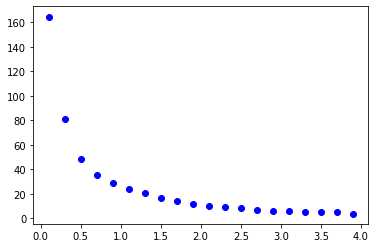

In [33]:

import matplotlib.pyplot as plt
plt.figure()
plt.errorbar(result['f_av'], result['A_real'], yerr=result['A_real_err'], fmt='o', label='Re[G]', color='blue')

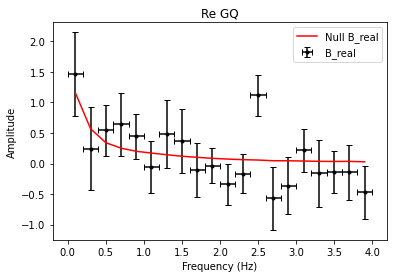

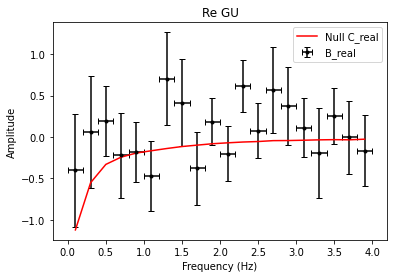

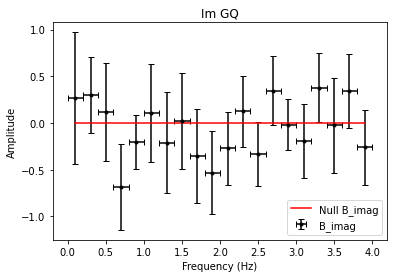

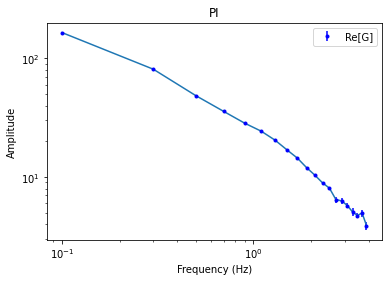

In [39]:
plt.figure()
plt.title('Re GQ')
plt.errorbar(result['f_av'], result['B_real'],xerr=[0.1]*20 ,yerr=result['B_real_err'], fmt='.', label='B_real', color='black',capsize=3)
#plt.errorbar(result['f_av'], result['C_real'],xerr=[0.1]*20 ,yerr=result['C_real_err'], fmt='.', label='C_real', color='red',capsize=3)
#plt.errorbar(result['f_av'], result['B_imag'],xerr=[0.1]*20 ,yerr=result['B_imag_err'], fmt='.', label='B_imag', color='green',capsize=3)
#plt.errorbar(result['f_av'], result['C_imag'],xerr=[0.1]*20 ,yerr=result['C_imag_err'], fmt='.', label='C_imag', color='orange',capsize=3)
plt.xlabel('Frequency (Hz)')
#plt.ylabel('Amplitude')
plt.legend()
#plt.figure()
#plt.errorbar(result['f_av'], result['A_null_real'], yerr=result['A_real_err'], fmt='o', label='Null Re[G]', color='blue')
plt.plot(result['f_av'], result['B_null_real'], label='Null B_real', color='red')
#plt.errorbar(result['f_av'], result['C_null_real'],xerr=[0.1]*20 ,yerr=result['C_real_err'], fmt='.', label='Null C_real', color='red',capsize=3)
#plt.errorbar(result['f_av'], result['B_null_imag'],xerr=[0.1]*20 ,yerr=result['B_imag_err'], fmt='.', label='Null B_imag', color='green',capsize=3)
#plt.errorbar(result['f_av'], result['C_null_imag'],xerr=[0.1]*20 ,yerr=result['C_imag_err'], fmt='.', label='Null C_imag', color='orange',capsize=3)
plt.xlabel('Frequency (Hz)')

plt.ylabel('Amplitude')
plt.legend()
plt.show()


plt.figure()
plt.title('Re GU')
plt.errorbar(result['f_av'], result['C_real'],xerr=[0.1]*20 ,yerr=result['C_real_err'], fmt='.', label='B_real', color='black',capsize=3)
#plt.errorbar(result['f_av'], result['C_real'],xerr=[0.1]*20 ,yerr=result['C_real_err'], fmt='.', label='C_real', color='red',capsize=3)
#plt.errorbar(result['f_av'], result['B_imag'],xerr=[0.1]*20 ,yerr=result['B_imag_err'], fmt='.', label='B_imag', color='green',capsize=3)
#plt.errorbar(result['f_av'], result['C_imag'],xerr=[0.1]*20 ,yerr=result['C_imag_err'], fmt='.', label='C_imag', color='orange',capsize=3)
plt.xlabel('Frequency (Hz)')
#plt.ylabel('Amplitude')
plt.legend()
#plt.figure()
#plt.errorbar(result['f_av'], result['A_null_real'], yerr=result['A_real_err'], fmt='o', label='Null Re[G]', color='blue')
plt.plot(result['f_av'], result['C_null_real'], label='Null C_real', color='red')
#plt.errorbar(result['f_av'], result['C_null_real'],xerr=[0.1]*20 ,yerr=result['C_real_err'], fmt='.', label='Null C_real', color='red',capsize=3)
#plt.errorbar(result['f_av'], result['B_null_imag'],xerr=[0.1]*20 ,yerr=result['B_imag_err'], fmt='.', label='Null B_imag', color='green',capsize=3)
#plt.errorbar(result['f_av'], result['C_null_imag'],xerr=[0.1]*20 ,yerr=result['C_imag_err'], fmt='.', label='Null C_imag', color='orange',capsize=3)
plt.xlabel('Frequency (Hz)')

plt.ylabel('Amplitude')
plt.legend()
plt.show()


plt.figure()
plt.title('Im GQ')
#plt.errorbar(result['f_av'], result['C_real'],xerr=[0.1]*20 ,yerr=result['C_real_err'], fmt='.', label='B_real', color='black',capsize=3)
#plt.errorbar(result['f_av'], result['C_real'],xerr=[0.1]*20 ,yerr=result['C_real_err'], fmt='.', label='C_real', color='red',capsize=3)
plt.errorbar(result['f_av'], result['B_imag'],xerr=[0.1]*20 ,yerr=result['B_imag_err'], fmt='.', label='B_imag', color='black',capsize=3)
#plt.errorbar(result['f_av'], result['C_imag'],xerr=[0.1]*20 ,yerr=result['C_imag_err'], fmt='.', label='C_imag', color='orange',capsize=3)
plt.xlabel('Frequency (Hz)')
#plt.ylabel('Amplitude')
plt.legend()
#plt.figure()
#plt.errorbar(result['f_av'], result['A_null_real'], yerr=result['A_real_err'], fmt='o', label='Null Re[G]', color='blue')
#plt.plot(result['f_av'], result['C_null_real'], label='Null C_real', color='red')
#plt.errorbar(result['f_av'], result['C_null_real'],xerr=[0.1]*20 ,yerr=result['C_real_err'], fmt='.', label='Null C_real', color='red',capsize=3)
plt.plot(result['f_av'], result['B_null_imag'], label='Null B_imag', color='red')
#plt.errorbar(result['f_av'], result['C_null_imag'],xerr=[0.1]*20 ,yerr=result['C_imag_err'], fmt='.', label='Null C_imag', color='orange',capsize=3)
plt.xlabel('Frequency (Hz)')

plt.ylabel('Amplitude')
plt.legend()
plt.show()


plt.figure()
plt.title('PI')
#plt.plot(a[11][0],a[9])
plt.xlabel('Frequency (Hz)')
#plt.plot(result[', result['cs_G_real_stacked'])
plt.errorbar(result['f_av'], result['A_real'], yerr=result['A_real_err'], fmt='.', label='Re[G]', color='blue')
plt.plot(result['f_av'], result['A_null_real'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()

#ax[0].errorbar(result['f_av'],result['A_null_real'], yerr=result['A_null_real_err'], fmt='o', label='Null Re[G]', color='red')

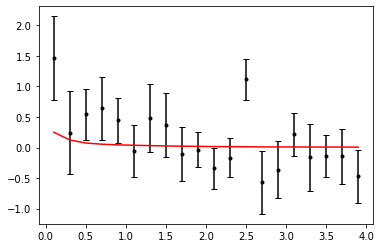

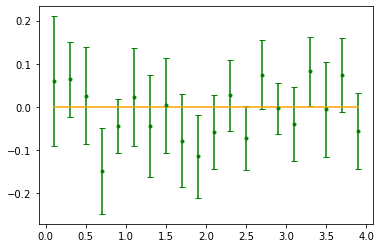

In [93]:
plt.figure()
plt.errorbar(result['f_av'], result['B_real'], yerr=result['B_real_err'], fmt='.', label='B_real', color='black',capsize=3)
plt.plot(result['f_av'], result['B_null_real'], label='Null B_real', color='red')

plt.figure()
plt.errorbar(result['f_av'], result['B_imag'], yerr=result['B_imag_err'], fmt='.', label='B_imag', color='green',capsize=3)
plt.plot(result['f_av'], result['B_null_imag'], label='Null B_imag', color='orange')